In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np
import xarray as xr
import os
import sys
import glob
import datetime
# Read station metadata from the Excel file
stations = pd.read_excel('/g/data/w28/yk8692/nesp/station/All_stations_information.xlsx')

In [2]:
%%time
file_path = '/g/data/w28/yk8692/nesp'
# Load the Greater Sydney shapefile
gccsa = gpd.read_file(f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp")
# gccsa = gpd.read_file("Greater Capital City Statistical Areas - 2021 - Shapefile.shp")
print("Shapefile columns:", gccsa.columns.tolist())
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains("Melbourne", case=False)]
print("Number of polygons for Greater Melbourne:", len(mel_shp))

# Convert station metadata into a GeoDataFrame.
stations_gdf = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations['Longitude'], stations['Latitude']),
    crs="EPSG:4326"
) 

# If necessary, reproject the Sydney shapefile to match the stations' CRS.
if mel_shp.crs != stations_gdf.crs:
    mel_shp = mel_shp.to_crs(stations_gdf.crs)

# Filter stations that fall within the Greater Sydney region.
stations_in_melbourne = stations_gdf[stations_gdf.within(mel_shp.unary_union)]
print(f"Found {len(stations_in_melbourne)} AWS stations within Greater Melbourne.")

def load_station_data(station_number, data_dir=f'{file_path}/station'):
    station_num_str = f"{int(station_number):06d}"
    pattern = os.path.join(data_dir, f"HD01D_Data_{station_num_str}_*.nc")
    file_list = glob.glob(pattern)
    if not file_list:
        print(f"No NetCDF files found for station {station_num_str}")
        return None
    try:
        ds = xr.open_mfdataset(file_list, combine='by_coords')
        return ds
    except Exception as e:
        print(f"Error loading station {station_num_str}: {e}")
        return None
# stations_in_sydney = stations_in_sydney[0]

highlight_stations = ['086068', '086282']

sydney_station_data_highlight = {}
for station in highlight_stations:
    ds = load_station_data(station)
    if ds is not None:
        sydney_station_data_highlight[station] = ds

print("Loaded data for the following highlighted station(s):", list(sydney_station_data_highlight.keys()))

Shapefile columns: ['GCC_CODE21', 'GCC_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21', 'geometry']
Number of polygons for Greater Melbourne: 1
Found 16 AWS stations within Greater Melbourne.
Loaded data for the following highlighted station(s): ['086068', '086282']
CPU times: user 37.5 s, sys: 5.47 s, total: 43 s
Wall time: 1min 6s


In [9]:
#test one station
data = sydney_station_data_highlight['086068']
# Assume 'data' is an xarray dataset
if 'Precipitation' in data.variables and 'Precipitation Quality' in data.variables:
    ppt = data['Precipitation']
    ppt_q = data['Precipitation Quality']

    # Apply quality control filter (Keep only 'Y' flagged data)
    ppt_quality_controlled = ppt.where(ppt_q == 'Y')

    # Define a precipitation threshold (parameterized)
    THRESHOLD = 30  # mm
    ppt_quality_controlled = ppt_quality_controlled.where(ppt_quality_controlled <= THRESHOLD)

    # Convert to Pandas DataFrame
    ppt_df = ppt_quality_controlled.to_dataframe().reset_index()

    # Ensure 'Time' column is in datetime format and set as index|
    ppt_df['Time'] = pd.to_datetime(ppt_df['Time'])
    ppt_df = ppt_df.set_index('Time')

    # Define aggregation intervals (rolling window step)
    intervals = {'5min': 1, '10min': 2, '20min': 4, '30min': 6, '1h': 12}  # Assuming 5-min time steps

    # Initialize an empty dictionary to store aggregated data
    ppt_aggregated = {}

    for interval, window in intervals.items():
        # Compute rolling sum for the given window and shift to maintain alignment
        ppt_aggregated[interval] = ppt_df['Precipitation'].rolling(window=window, min_periods=1).sum().shift(-window + 1)

    # Convert dictionary to DataFrame
    ppt_aggregated_df = pd.DataFrame(ppt_aggregated, index=ppt_df.index)

    # Drop NaNs that arise due to shifting
    ppt_aggregated_df = ppt_aggregated_df.dropna()

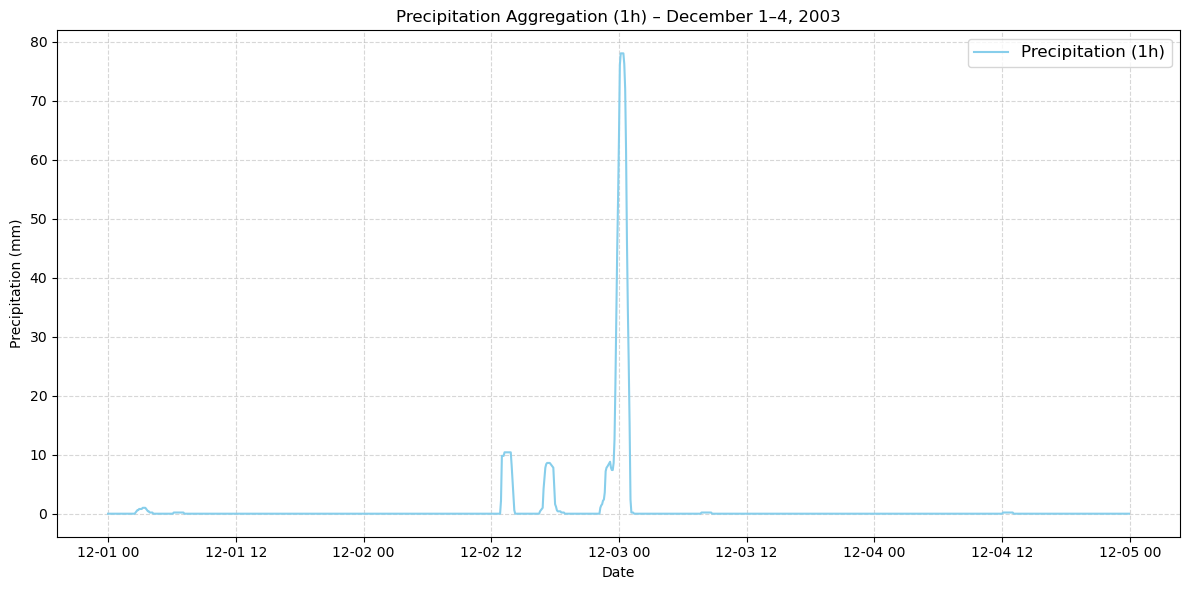

In [12]:
# Plot precipitation aggregation from 2003-12-01 to 2003-12-04 ('1h' interval)
fig, ax = plt.subplots(figsize=(12, 6))

interval = '1h'  # Aggregation interval

# Select data from December 1 to December 4, 2003
ppt_dec_range = ppt_aggregated_df.loc['2003-12-01':'2003-12-04']

# Plot the selected data range
ax.plot(
    ppt_dec_range.index, 
    ppt_dec_range[interval], 
    color='skyblue', 
    label=f'Precipitation ({interval})'
)

# Formatting plot
ax.set_ylabel('Precipitation (mm)')
ax.set_xlabel('Date')
ax.set_title(f'Precipitation Aggregation ({interval}) – December 1–4, 2003', fontsize=12)
ax.grid(linestyle="--", alpha=0.5)

# Legend
ax.legend(loc="upper right", fontsize=12, frameon=True)

plt.tight_layout()
plt.show()


In [3]:
# List of highlighted station numbers
station_numbers = [
    '086068', '086282'
]

# Dictionary to store the top 10 extreme events for each station
all_stations_top_events = {}

# Process each station separately
for station in station_numbers:
    # Get data for the station from the sydney_station_data dictionary
    data = sydney_station_data_highlight.get(station)
    
    # Check if data exists and has the required variables
    if data is None or 'Precipitation' not in data.variables or 'Precipitation Quality' not in data.variables:
        continue  # Skip this station if data is missing or invalid

    # Extract precipitation data and quality flag
    ppt = data['Precipitation']
    ppt_q = data['Precipitation Quality']

    # Apply quality control filter: keep only 'Y' flagged data
    ppt_quality_controlled = ppt.where(ppt_q == 'Y')

    # Apply a precipitation threshold (e.g., exclude values > 30 mm)
    THRESHOLD = 50  # mm
    ppt_quality_controlled = ppt_quality_controlled.where(ppt_quality_controlled <= THRESHOLD)

    # Convert to Pandas DataFrame and set Time index
    ppt_df = ppt_quality_controlled.to_dataframe().reset_index()
    ppt_df['Time'] = pd.to_datetime(ppt_df['Time'])
    ppt_df = ppt_df.set_index('Time')

    # Define aggregation intervals (using 5-min time steps)
    intervals = {'5min': 1, '10min': 2, '20min': 4, '30min': 6, '1h': 12}
    duration_factors = {'5min': 5, '10min': 10, '20min': 20, '30min': 30, '1h': 60}  # Dictionary with minute values
    # Initialize a dictionary to store aggregated data
    ppt_aggregated = {}
    for interval, window in intervals.items():
        # Compute rolling sum over the window and align with the last time step (end-point aggregation)
        ppt_aggregated[interval] = ppt_df['Precipitation'].rolling(window=window, min_periods=1).sum().shift(-window + 1)
        ppt_aggregated[interval] = ppt_aggregated[interval] / duration_factors[interval] # to mm/min
        
    # Convert aggregated data dictionary to a DataFrame
    ppt_aggregated_df = pd.DataFrame(ppt_aggregated, index=ppt_df.index)
    ppt_aggregated_df = ppt_aggregated_df.dropna().reset_index()
    ppt_aggregated_df.set_index('Time', inplace=True)

    # Calculate the 90th percentile for each column (per year)
    percentiles = ppt_aggregated_df.quantile(0.90)
    
    # Filter rows that exceed the 90th percentile and are above a minimum threshold (0.2 mm)
    filtered_df = ppt_aggregated_df[(ppt_aggregated_df >= percentiles) & (ppt_aggregated_df > 0.2)]

    # Identify pseudo-independent events (local maxima) 
    # (using <= for adjacent comparison to allow plateaus)
    maxima_df = filtered_df[
        (filtered_df.shift(-1).fillna(-1) <= filtered_df) &
        (filtered_df.shift(1).fillna(-1) <= filtered_df)
    ]

    # Identify the highest value per day for each column
    daily_max = maxima_df.groupby(maxima_df.index.date).max()

    # Identify the exact timestamps of these daily maxima
    daily_max_times = maxima_df.groupby(maxima_df.index.date).idxmax()

    # Create a list to store DataFrames for each duration (column)
    max_events_list = []
    for col in daily_max.columns:
        # Drop missing timestamps before indexing
        valid_times = daily_max_times[col].dropna()
        if not valid_times.empty:
            # Get the actual values at those timestamps (drop any further NaNs)
            values = maxima_df[col].loc[valid_times].dropna()
            # Create a DataFrame for this duration using the valid timestamps as index
            df_col = pd.DataFrame({col: values}, index=valid_times)
            max_events_list.append(df_col)

    # If we have any events, combine the results
    if max_events_list:
        max_events_per_day = pd.concat(max_events_list, axis=1)
        max_events_per_day.index = pd.to_datetime(max_events_per_day.index)
        max_events_per_day.sort_index(inplace=True)
        
        # (Optional) Handle consecutive high-rainfall days by grouping, if desired:
        # max_events_per_day['Date'] = max_events_per_day.index.date
        # max_events_per_day['Group'] = (pd.to_datetime(max_events_per_day.index).to_series().diff().gt(pd.Timedelta(days=1))).cumsum()
        # selected_events = max_events_per_day.groupby('Group').apply(lambda g: g.nlargest(1, 'Precipitation'))
        
        # For each duration, select only the top 10 highest events
        top_events = max_events_per_day.apply(lambda x: x.nlargest(10))
        all_stations_top_events[station] = top_events

# Combine results from all stations into one DataFrame, adding a "Station" column
combined_events = []
for station, df in all_stations_top_events.items():
    df = df.copy()
    df['Station'] = station
    combined_events.append(df)
combined_df = pd.concat(combined_events)

# Reset index so that "Time" is a column if desired
combined_df = combined_df.reset_index().rename(columns={'index': 'Time'})
print(combined_df)

                  Time  5min  10min  20min     30min    1h Station
0  2003-12-02 13:55:00  1.52    NaN    NaN       NaN   NaN  086068
1  2003-12-03 00:10:00   NaN    NaN    NaN       NaN  1.30  086068
2  2003-12-03 00:35:00   NaN    NaN   2.32  2.320000   NaN  086068
3  2003-12-03 00:40:00  3.04   2.68    NaN       NaN   NaN  086068
4  2006-02-09 17:05:00  1.32    NaN    NaN       NaN   NaN  086068
..                 ...   ...    ...    ...       ...   ...     ...
69 2020-01-15 15:50:00   NaN    NaN    NaN  0.780000   NaN  086282
70 2020-01-15 15:55:00   NaN    NaN   0.85       NaN   NaN  086282
71 2022-12-22 15:55:00   NaN    NaN    NaN       NaN  0.72  086282
72 2022-12-22 16:15:00   NaN    NaN   1.99  1.433333   NaN  086282
73 2022-12-22 16:20:00  2.56   2.36    NaN       NaN   NaN  086282

[74 rows x 7 columns]


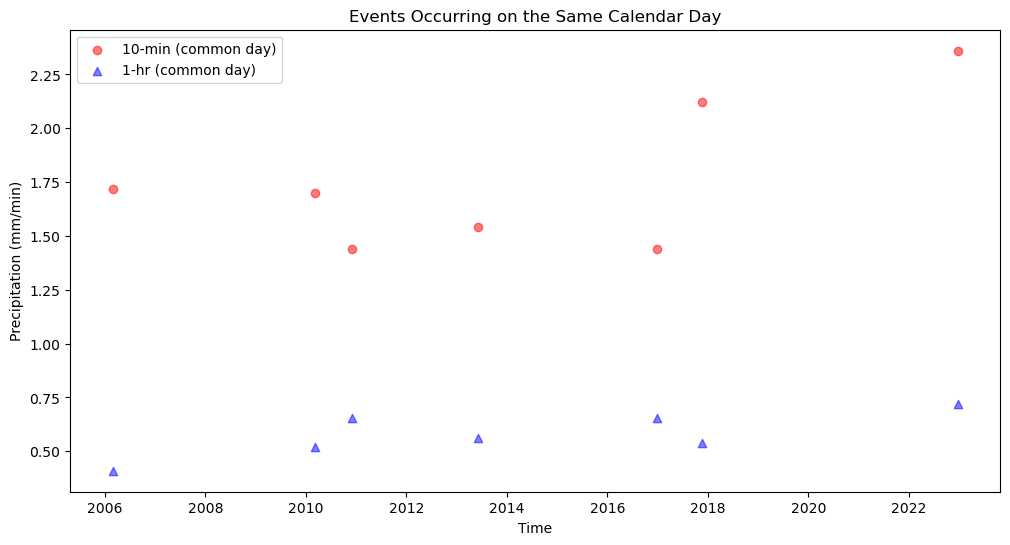

In [22]:
import matplotlib.pyplot as plt

# Suppose 'df' is the DataFrame of local maxima for a station 
# (like max_events_per_day in your script).
# Each row is a timestamp index with columns ['5min','10min','20min','30min','1h']
# and possibly many NaNs if an event is only for a certain duration.

ten_min_df = df.dropna(subset=['10min']).copy()
one_hr_df = df.dropna(subset=['1h']).copy()

ten_min_df['Date'] = ten_min_df.index.date
one_hr_df['Date'] = one_hr_df.index.date

ten_min_days = set(ten_min_df['Date'])
one_hr_days  = set(one_hr_df['Date'])
common_days  = ten_min_days.intersection(one_hr_days)

overlap_10min_df = ten_min_df[ten_min_df['Date'].isin(common_days)]
overlap_1hr_df   = one_hr_df[one_hr_df['Date'].isin(common_days)]

# # Identify rows with valid (non-null) 10min AND 1h
# overlap_df = df.dropna(subset=['10min', '1h'])

plt.figure(figsize=(12,6))

# # Plot 10-min extremes (red circles)
# plt.scatter(ten_min_df.index, ten_min_df['10min'], 
#             color='red', marker='o', alpha=0.6, label='10-min extremes')

# # Plot 1-hr extremes (blue triangles)
# plt.scatter(one_hr_df.index, one_hr_df['1h'], 
#             color='blue', marker='^', alpha=0.6, label='1-hr extremes')

# # Plot overlap events (purple X)
# plt.scatter(overlap_df.index, overlap_df['10min'], 
#             color='purple', marker='x', s=100, 
#             label='Overlap (10-min & 1-hr)')

# Plot 10-min events on shared days
plt.scatter(overlap_10min_df.index, overlap_10min_df['10min'], 
            color='red', marker='o', alpha=0.5, label='10-min (common day)')

# Plot 1-hr events on shared days
plt.scatter(overlap_1hr_df.index, overlap_1hr_df['1h'], 
            color='blue', marker='^', alpha=0.5, label='1-hr (common day)')

plt.xlabel("Time")
plt.ylabel("Precipitation (mm/min)")
# plt.title("10-min vs. 1-hr Extreme Events and Their Overlap")
plt.title("Events Occurring on the Same Calendar Day")
plt.legend()
# plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [4]:
# Ensure that there is a 'Time' column and convert it to datetime
combined_df['Time'] = pd.to_datetime(combined_df['Time'])

# Create a new column 'Date' containing only the date (no time)
combined_df['Date'] = combined_df['Time'].dt.date

# Now group by 'Date' and filter days that have non-null values in both '10min' and '1h'
common_days_df = combined_df.groupby('Date').filter(
    lambda g: g['10min'].notna().any() and g['1h'].notna().any()
)

# Then, for each common day, you can aggregate (e.g., by taking the maximum) the 10min and 1h values:
daily_max = common_days_df.groupby('Date').agg({'10min': 'max', '1h': 'max'})

# Convert the index to datetime for plotting (using January 1st of the year, for example, or simply the date)
daily_max.index = pd.to_datetime(daily_max.index.astype(str))
print(daily_max)

            10min        1h
Date                       
2003-12-03   2.68  1.300000
2006-02-25   1.72  0.410000
2010-03-06   1.70  0.520000
2010-12-01   1.44  0.653333
2010-12-02   1.42  0.340000
2011-03-13   1.50  0.480000
2013-05-31   1.54  0.563333
2016-12-29   2.72  1.193333
2017-11-18   2.12  0.540000
2018-12-14   1.18  0.480000
2022-08-11   1.80  0.680000
2022-12-22   2.36  0.720000


In [6]:
# For 10-min extremes:
top4_10min = daily_max.nlargest(4, '10min')
print(top4_10min)

# For 1-hr extremes:
top4_1h = daily_max.nlargest(4, '1h')
print(top4_1h)

top4_combined = pd.concat([top4_10min, top4_1h], axis=1)
print(top4_combined)

            10min        1h
Date                       
2016-12-29   2.72  1.193333
2003-12-03   2.68  1.300000
2022-12-22   2.36  0.720000
2017-11-18   2.12  0.540000
            10min        1h
Date                       
2003-12-03   2.68  1.300000
2016-12-29   2.72  1.193333
2022-12-22   2.36  0.720000
2022-08-11   1.80  0.680000
            10min        1h  10min        1h
Date                                        
2003-12-03   2.68  1.300000   2.68  1.300000
2016-12-29   2.72  1.193333   2.72  1.193333
2017-11-18   2.12  0.540000    NaN       NaN
2022-08-11    NaN       NaN   1.80  0.680000
2022-12-22   2.36  0.720000   2.36  0.720000


/jobfs/137508708.gadi-pbs/ipykernel_3832123/1014761444.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top4_combined = daily_max_long.groupby('Duration').apply(lambda x: x.nlargest(4, 'Precipitation')).reset_index(drop=True)


        Date Duration  Precipitation
0 2016-12-29    10min       2.720000
1 2003-12-03    10min       2.680000
2 2022-12-22    10min       2.360000
3 2017-11-18    10min       2.120000
4 2003-12-03       1h       1.300000
5 2016-12-29       1h       1.193333
6 2022-12-22       1h       0.720000
7 2022-08-11       1h       0.680000


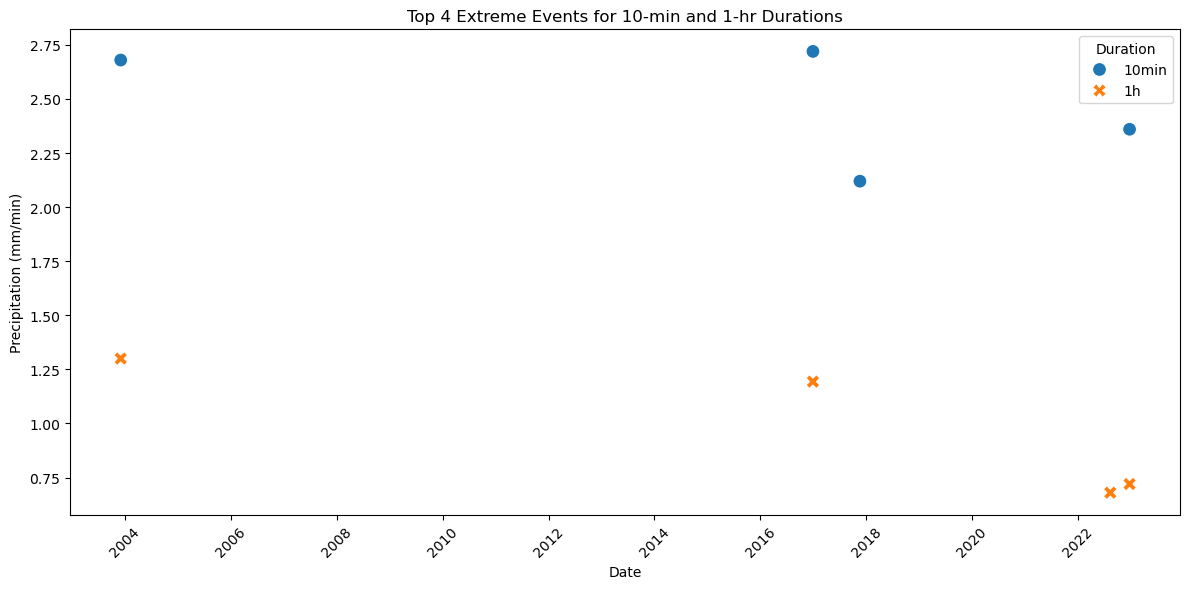

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume daily_max is your DataFrame with index 'Date' and columns for different durations, e.g. '10min' and '1h'.
# Reset index so that 'Date' becomes a column.
daily_max_reset = daily_max.reset_index()

# Melt the DataFrame into long format: one row per event, with columns "Date", "Duration", and "Precipitation"
daily_max_long = daily_max_reset.melt(id_vars='Date', value_vars=['10min', '1h'], 
                                        var_name='Duration', value_name='Precipitation')

# For each Duration, select the top 4 extreme events (largest precipitation values)
top4_combined = daily_max_long.groupby('Duration').apply(lambda x: x.nlargest(4, 'Precipitation')).reset_index(drop=True)
print(top4_combined)

# Plot the combined top events
plt.figure(figsize=(12,6))
sns.scatterplot(data=top4_combined, x='Date', y='Precipitation', 
                hue='Duration', style='Duration', s=100)
plt.xlabel("Date")
plt.ylabel("Precipitation (mm/min)")
plt.title("Top 4 Extreme Events for 10-min and 1-hr Durations")
plt.xticks(rotation=45)
plt.legend(title='Duration', fontsize=10)
plt.tight_layout()
plt.show()
